# Validation Service Benchmarks


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pprint import pprint

# Loading Data

In [2]:
metric_options = [
    ("timestamp", "Timestamp MS since Epoch"), #0
    ("CPU_ALL:User%", "CPU Total: User %", [0,100]), # 1
    ("MEM:memtotal", "Memory MB: Total", [0,65000]), #2
    ("MEM:swapfree", "Memory MB: Swap Free", [0,1000]), #3
    ("MEM:active", "Memory MB: Active", [0,65000]), #4
    ("MEM:inactive", "Memory MB: Inactive", [0,65000]), #5
    ("NET:eno1-write-KB/s", "Network Write KB/s", [0,20000]), #6
    ("NET:eno1-read-KB/s", "Network Read KB/s", [0,20000]), #7
    ("DISKBUSY:sda", "Disk Busy %: /dev/sda", [0,100]), #8
    ("DISKREAD:sda", "Disk Read KB/s: /dev/sda", [0,10000]), #9
    ("DISKWRITE:sda", "Disk Write KB/s: /dev/sda", [0,10000]), #10
    ("VM:pgfault", "Paging and Virtual Memory: Page Faults", [0,100]) #11
]

# Configuration
benchmark_dir = "experiment_0"
chosen_metric = metric_options[6]
metric_header = chosen_metric[0]
metric_name = chosen_metric[1]
y_axis_limits = chosen_metric[2]

dataframes = []
for i in range(0, 25):
    machine_id = f"lattice-{150+i}"
    filename = f"{i}-{machine_id}.nmon.csv"
    filepath = f"{benchmark_dir}/{filename}"
    dataframes.append(pd.read_csv(filepath, header=0).pop(metric_header))


# Plotting

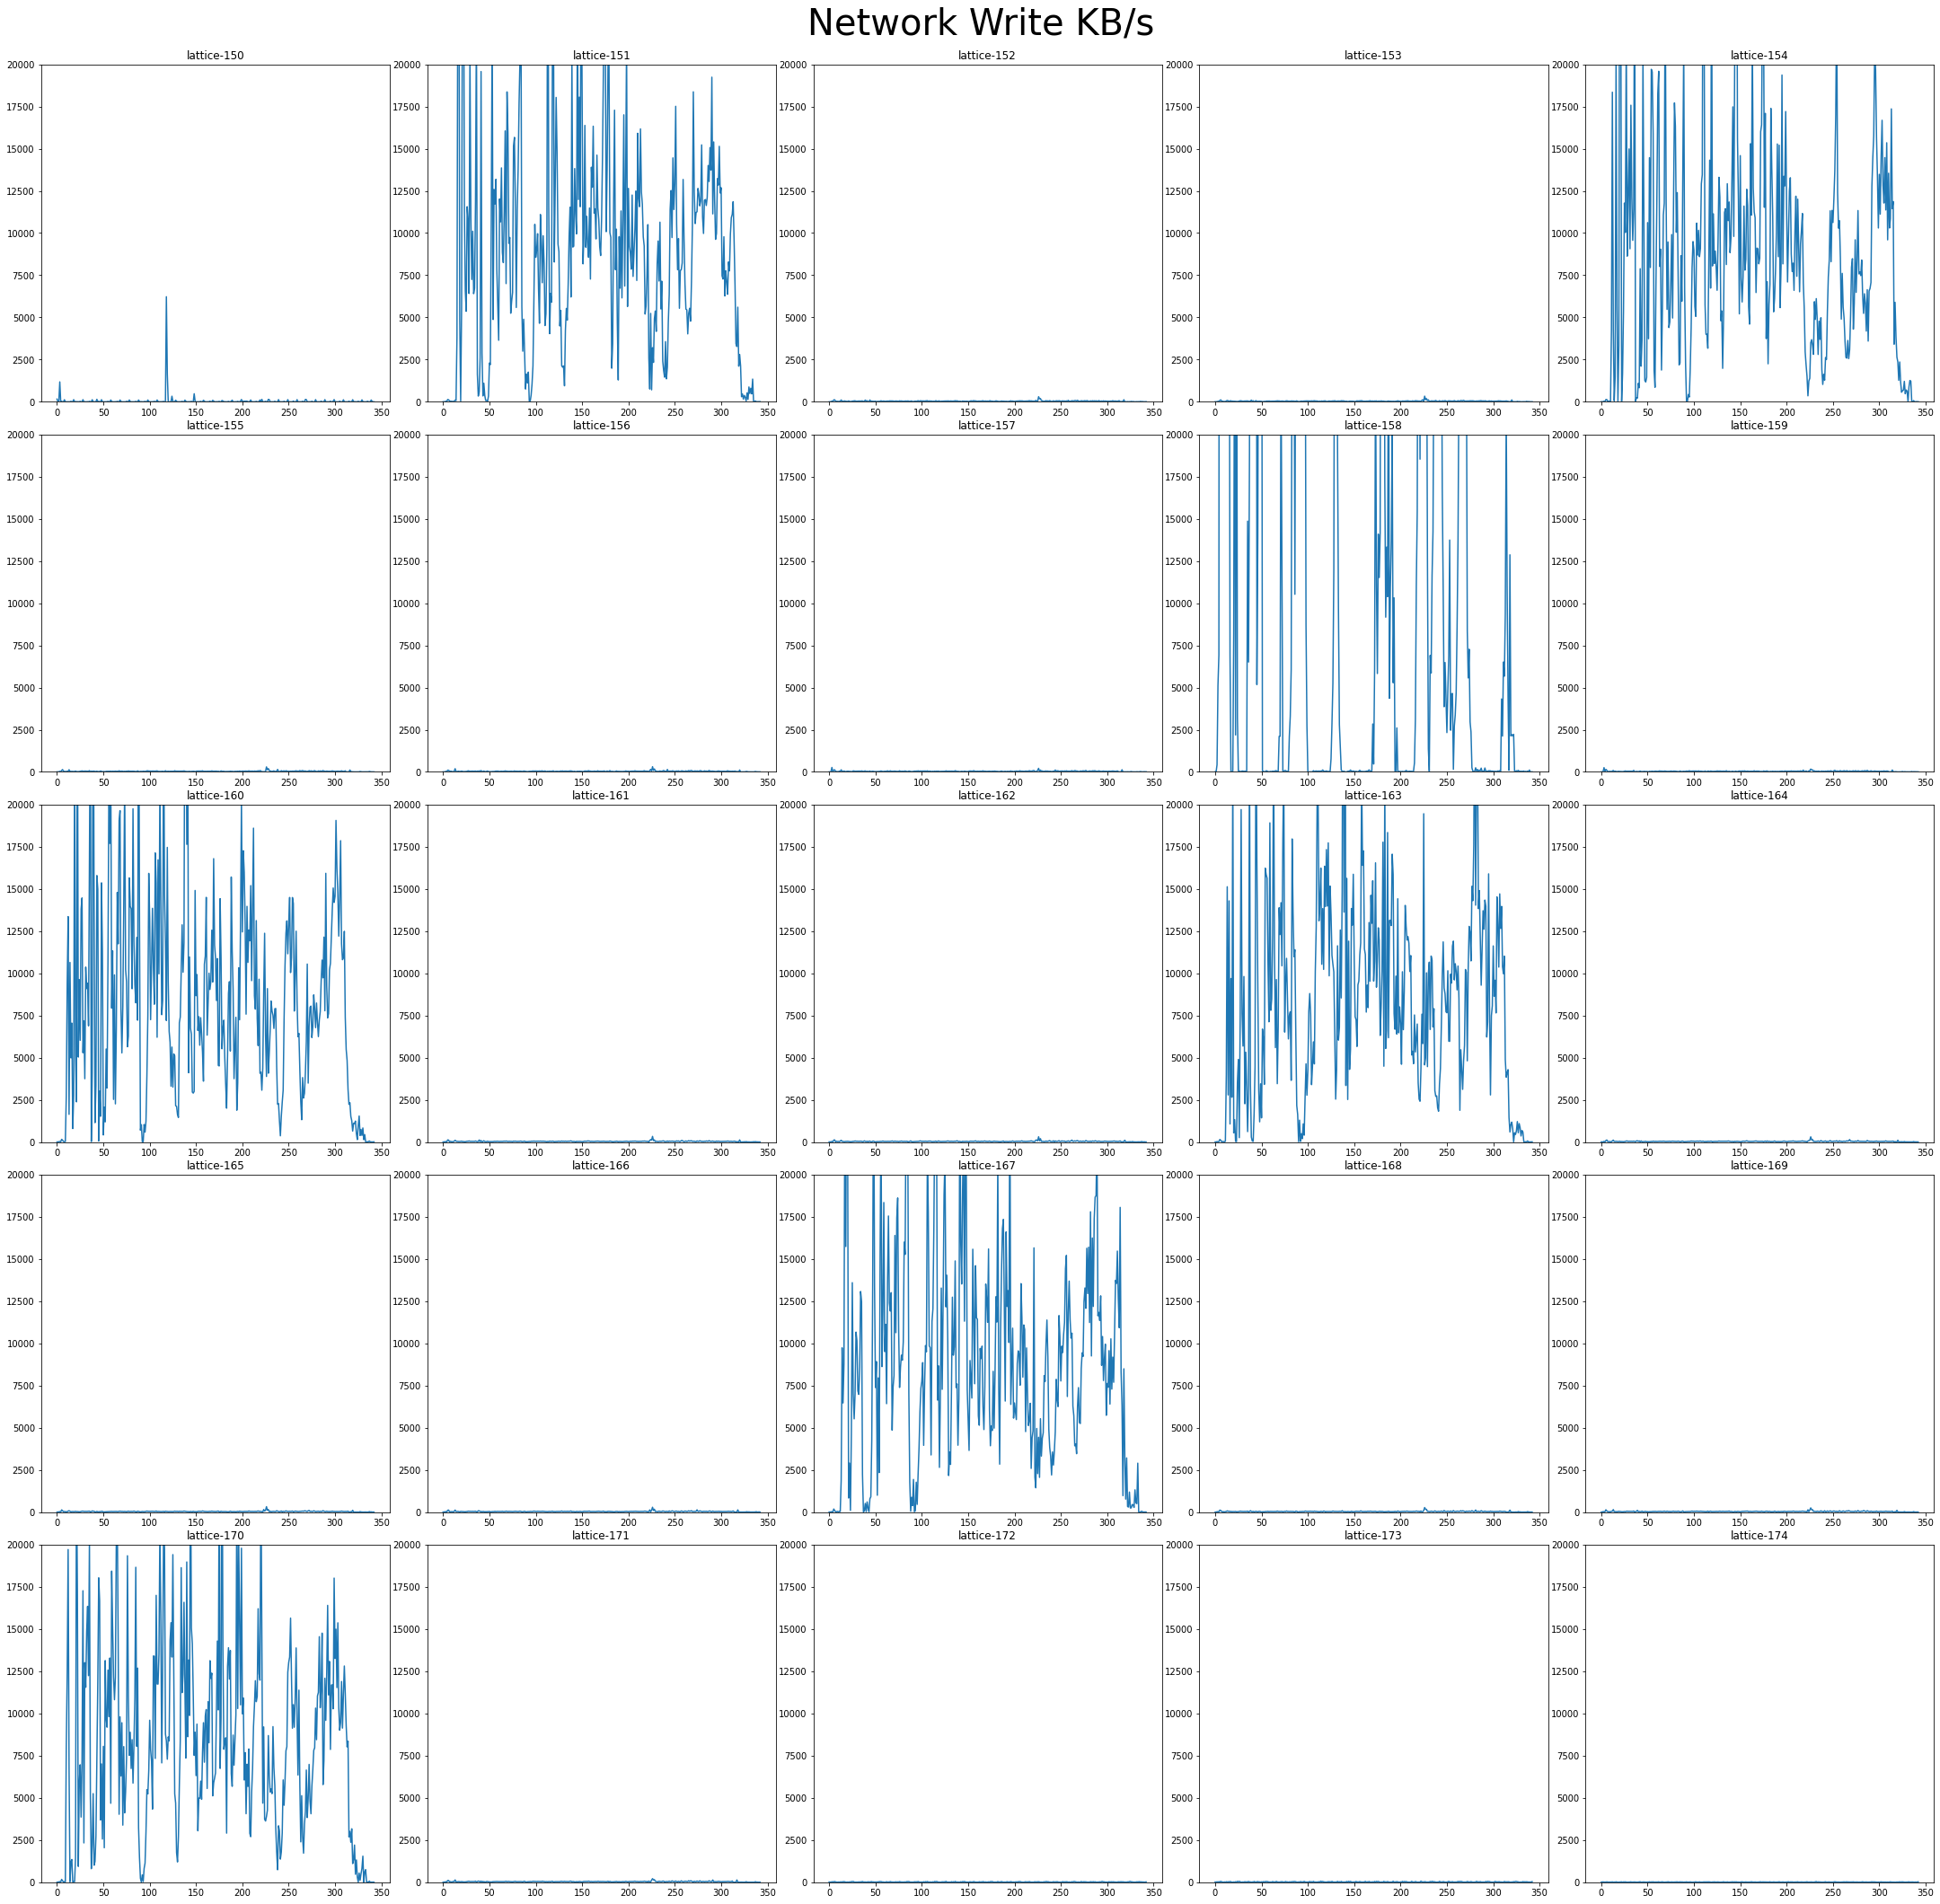

In [3]:
number_rows = 5
number_cols = 5

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 30))
fig.tight_layout(h_pad=1.7)
fig.suptitle(metric_name, fontsize=40)

index = 0
for i in range(number_rows):
    for j in range(number_cols):
        ax[i,j].set_ylim(y_axis_limits)
        ax[i,j].plot(dataframes[index], label=f"Machine {index}")
        ax[i,j].set_title(f"lattice-{150+index}")
        index += 1

plt.subplots_adjust(top=0.95)
plt.show()

Total response duration: 338.0137759579811 seconds


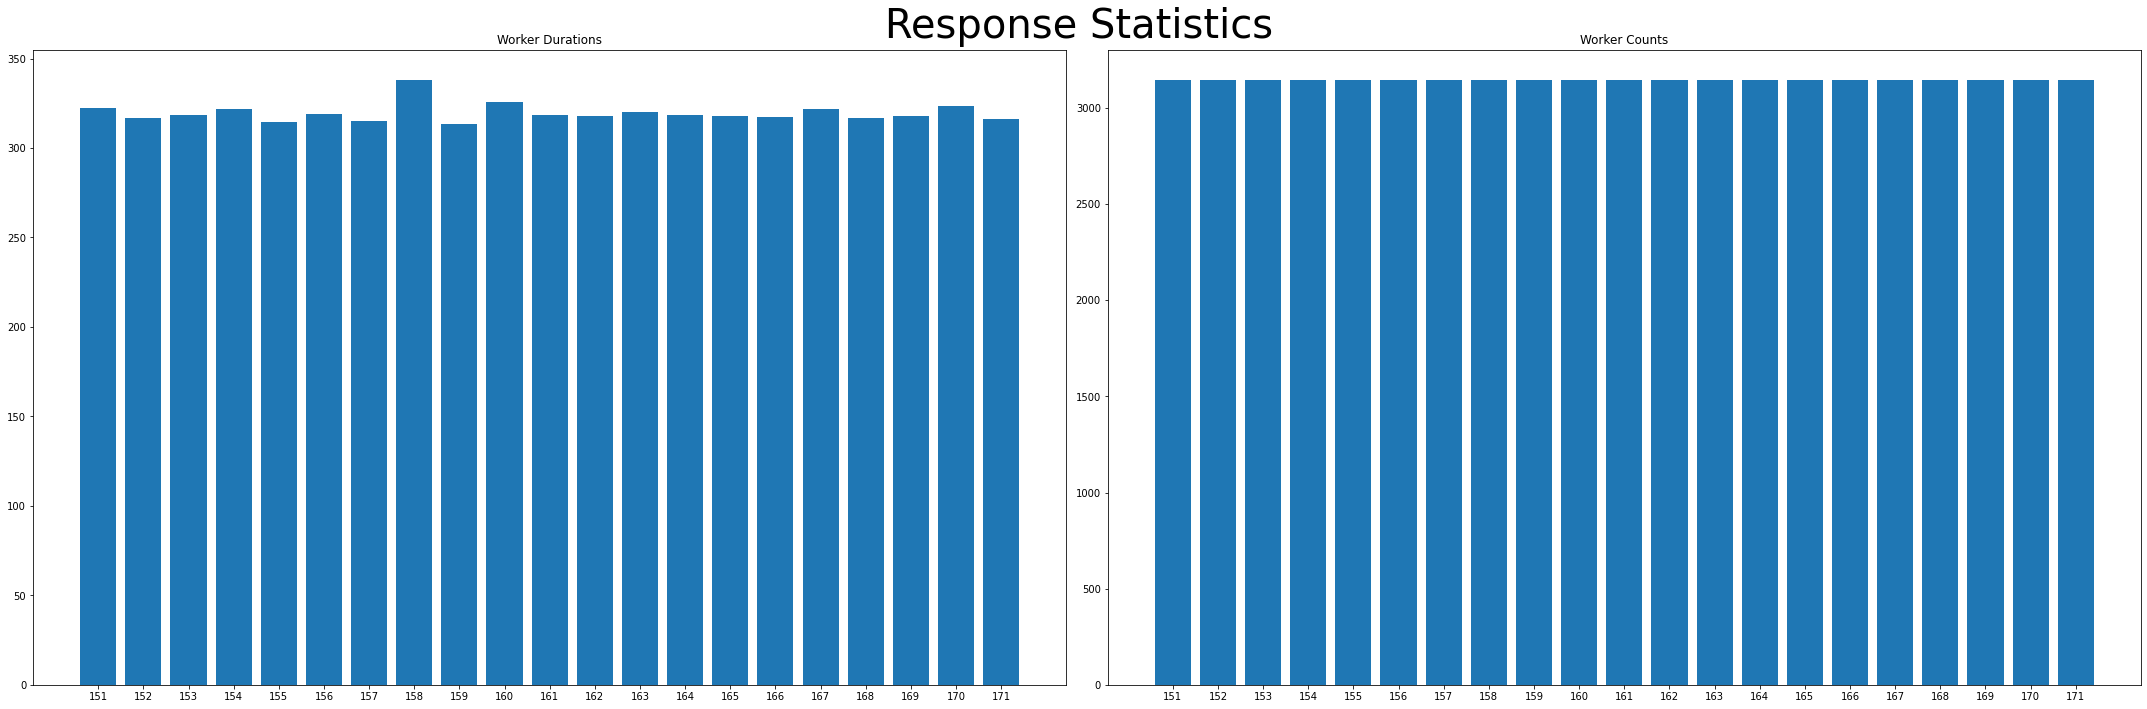

In [4]:
response_filename = f"{benchmark_dir}/response.json"

with open(response_filename, "r") as response_file:
    response = json.load(response_file)

worker_durations = []
worker_counts = []
for worker_response in response["worker_responses"]:
    worker_counts.append((worker_response["hostname"], len(worker_response["metrics"])))
    worker_durations.append((worker_response["hostname"], worker_response["duration_sec"]))

worker_durations.sort(key=lambda y: y[0])
worker_durations_vals = [x[1] for x in worker_durations]
worker_durations_names = [x[0][-3:] for x in worker_durations]

worker_counts.sort(key=lambda y: y[0])
worker_counts_vals = [x[1] for x in worker_counts]
worker_counts_names = [x[0][-3:] for x in worker_counts]

worker_durations.sort(key=lambda y: y[0])
worker_durations_vals = [x[1] for x in worker_durations]
worker_durations_names = [x[0][-3:] for x in worker_durations]

print(f"Total response duration: {response['duration_sec']} seconds")

number_rows = 1
number_cols = 2

fig, ax = plt.subplots(nrows=number_rows, ncols=number_cols, figsize=(30, 10))
fig.tight_layout(h_pad=1.7)
fig.suptitle("Response Statistics", fontsize=40)

ax[0].bar(worker_durations_names, worker_durations_vals)
ax[0].set_title(f"Worker Durations")

ax[1].bar(worker_counts_names, worker_counts_vals)
ax[1].set_title(f"Worker Counts")

plt.subplots_adjust(top=0.92)

plt.show()